# Create .h5 database step by step (sword)

## Table of contents
1. [Create filenames list to load](#create)
2. [Try to load single file: Markers and Analogs data](#single)
    - [Analogs (EMG)](#emg)
    - [Markers (marker, GRF, angles, forces, moment, power)](#marker)
3. [Attempt to connect  Analogs and Markers data sets](#connect)
4. [Big function to create 3D](#data)
    - [X vector](#x)
5. [Create.h5 file with only x vector](#xh5)
    - [Y vector](#y)
5. [Testing unload data](#testing)
6. [Create .h5 database](#h5)


#### 1. Create filenames list to load   <a name="create"></a>

In [1]:
input_folder = r'\\172.16.10.4\Praktyki2020\kk_database'

In [2]:
import glob

In [3]:
def get_filenames_form_path(input_folder):
    
    files_list = glob.glob(f'{input_folder}\\*.c3d', recursive=True)
    print("Load filenames:", len(files_list), "- we expect 15 person * 5 moves * 10 times = 3 750 filenames")
    
    return files_list

files_list = get_filenames_form_path(input_folder)

Load filenames: 3809 - we expect 15 person * 5 moves * 10 times = 3 750 filenames


In [4]:
def match_filenames(files_list):
    matchers_1 = ['T01','T02','T03','T04','T05']
    matchers_2 = ['K1', 'K2', 'K3', 'K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'K10']

    interesting_filenames = [s for s in files_list if any(xs in s for xs in matchers_1)]
    matching_filenames = [s for s in interesting_filenames if any(xs in s for xs in matchers_2)]

    missing = len(files_list) - len(matching_filenames)

    print("Successful loading, samples after validation of the repetitions:", len(interesting_filenames), "- so it's missing", missing, "samples" )
    
    return matching_filenames

In [5]:
filenames = match_filenames(files_list)
# filenames

Successful loading, samples after validation of the repetitions: 3680 - so it's missing 129 samples


#### 2. Try to load single file: Markers and Analogs data    <a name="single"></a>
- **Analogs (EMG)** <a name="emg"></a>

In [6]:
from pyomeca import Markers, Analogs

In [7]:
def read_analog_to_dataframe(filename, preprocesing = False, time_normalisation = False):
    muscles = ["Voltage.1","Voltage.2","Voltage.3","Voltage.4",
               "Voltage.5","Voltage.6","Voltage.7","Voltage.8",
               "Voltage.9","Voltage.10","Voltage.11","Voltage.12",
               "Voltage.13","Voltage.14","Voltage.15","Voltage.16"]
    
    emg = Analogs.from_c3d(filename, usecols=muscles)
    
    if preprocesing:
            emg = (
                emg.meca.band_pass(order=2, cutoff=[10, 425])
                .meca.center()
                .meca.abs()
                .meca.low_pass(order=4, cutoff=5, freq=emg.rate)
                .meca.normalize(ref=None, scale=1)
            )
    else:
        pass
    
    if time_normalisation: 
        emg = emg.meca.time_normalize(n_frames=time_normalisation)
    else:
        pass
        
    emg_dataframe = emg.meca.to_wide_dataframe()
    emg_dataframe = emg_dataframe[muscles]
    
    return emg_dataframe

In [8]:
emg_df = read_analog_to_dataframe(filenames[0])
emg_df

channel,Voltage.1,Voltage.2,Voltage.3,Voltage.4,Voltage.5,Voltage.6,Voltage.7,Voltage.8,Voltage.9,Voltage.10,Voltage.11,Voltage.12,Voltage.13,Voltage.14,Voltage.15,Voltage.16
time,,,,,,,,,,,,,,,,
0.000,0.003903,-0.005006,-0.004863,0.005207,-0.003764,-0.008394,-0.018764,-0.008400,-0.004374,-0.010762,0.001699,-0.026604,-0.001003,-0.000471,-0.005223,-0.003836
0.001,0.001309,-0.010652,-0.008525,-0.006237,-0.005137,-0.013734,-0.023036,-0.008247,-0.028635,-0.011220,0.005667,-0.031029,-0.005733,-0.002760,-0.005376,-0.006736
0.002,0.003140,-0.008516,-0.006236,-0.004254,-0.005290,-0.010225,-0.025020,-0.002907,-0.021464,-0.007405,0.007040,-0.015465,-0.003139,0.001207,0.001796,-0.005820
0.003,-0.004336,-0.010652,-0.013561,-0.018292,-0.007426,-0.010377,-0.026393,-0.010841,-0.009409,-0.007100,-0.001658,-0.002800,-0.003902,-0.000319,0.007594,-0.003684
0.004,-0.009219,-0.008210,-0.010204,-0.028210,-0.006358,-0.010225,-0.023494,-0.010231,-0.007273,-0.003285,-0.005625,-0.001579,-0.001308,0.001665,0.014613,-0.002310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3.280,-0.023868,-0.007753,-0.002117,-0.012188,-0.003611,-0.007631,-0.005641,-0.001534,-0.034739,-0.002827,-0.010813,-0.001121,-0.004207,-0.004896,-0.010106,0.009439
3.281,-0.023410,-0.006379,0.003071,0.000782,-0.005900,-0.009767,-0.002742,-0.000313,-0.031382,-0.004048,-0.003031,-0.022636,-0.006649,-0.002455,-0.005528,0.036294
3.282,-0.023868,-0.007448,0.001546,-0.001660,-0.004527,-0.010530,-0.004116,0.002281,-0.025431,-0.005269,0.001089,-0.037437,-0.005581,-0.003370,-0.005071,0.073068


In [9]:
emg_df = read_analog_to_dataframe(filenames[0], preprocesing = True)
emg_df

channel,Voltage.1,Voltage.2,Voltage.3,Voltage.4,Voltage.5,Voltage.6,Voltage.7,Voltage.8,Voltage.9,Voltage.10,Voltage.11,Voltage.12,Voltage.13,Voltage.14,Voltage.15,Voltage.16
time,,,,,,,,,,,,,,,,
0.000,0.130209,-0.002841,0.039229,0.019872,-0.005555,0.004186,0.007467,0.006612,0.038659,0.006921,0.005150,0.137743,0.010068,0.019596,0.042196,0.032482
0.001,0.134482,-0.002437,0.040732,0.021271,-0.004959,0.004688,0.007938,0.005743,0.044993,0.007142,0.005747,0.139689,0.010137,0.020496,0.045231,0.035132
0.002,0.138768,-0.002032,0.042239,0.022666,-0.004362,0.005190,0.008409,0.004878,0.051315,0.007363,0.006340,0.141630,0.010200,0.021397,0.048265,0.037776
0.003,0.143065,-0.001628,0.043748,0.024057,-0.003764,0.005691,0.008877,0.004018,0.057623,0.007586,0.006931,0.143564,0.010260,0.022296,0.051297,0.040414
0.004,0.147372,-0.001224,0.045260,0.025444,-0.003164,0.006190,0.009344,0.003165,0.063915,0.007809,0.007518,0.145492,0.010316,0.023195,0.054327,0.043045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3.280,0.303972,0.017332,0.118498,0.122743,0.092152,0.041344,0.048439,0.042135,0.372751,0.013873,0.036002,0.299654,0.031056,0.047301,0.091909,0.172446
3.281,0.303963,0.017331,0.118495,0.122743,0.092149,0.041345,0.048438,0.042136,0.372751,0.013874,0.036003,0.299657,0.031056,0.047302,0.091912,0.172454
3.282,0.303956,0.017331,0.118492,0.122743,0.092147,0.041346,0.048437,0.042137,0.372752,0.013874,0.036004,0.299660,0.031056,0.047303,0.091914,0.172461


In [10]:
emg_df = read_analog_to_dataframe(filenames[0], preprocesing = True, time_normalisation = 200)
emg_df

channel,Voltage.1,Voltage.2,Voltage.3,Voltage.4,Voltage.5,Voltage.6,Voltage.7,Voltage.8,Voltage.9,Voltage.10,Voltage.11,Voltage.12,Voltage.13,Voltage.14,Voltage.15,Voltage.16
time,,,,,,,,,,,,,,,,
0.000000,0.130209,-0.002841,0.039229,0.019872,-0.005555,0.004186,0.007467,0.006612,0.038659,0.006921,0.005150,0.137743,0.010068,0.019596,0.042196,0.032482
0.016503,0.201241,0.003736,0.064019,0.042193,0.004429,0.012272,0.014918,-0.006486,0.140207,0.010618,0.014492,0.168569,0.010736,0.034189,0.091508,0.074979
0.033005,0.268112,0.009784,0.086515,0.061725,0.014721,0.019497,0.021063,-0.012998,0.229023,0.014144,0.022229,0.193986,0.011117,0.047167,0.136147,0.112554
0.049508,0.324083,0.014955,0.103550,0.077350,0.025598,0.025512,0.025251,-0.005828,0.297573,0.017104,0.027847,0.211257,0.012984,0.057248,0.172712,0.142858
0.066010,0.365684,0.019108,0.113134,0.088884,0.037614,0.030447,0.027344,0.022264,0.342615,0.019238,0.031328,0.220200,0.018886,0.063837,0.200135,0.165363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3.217990,0.317741,0.018200,0.125802,0.123157,0.098964,0.038880,0.050994,0.041715,0.372242,0.013267,0.035567,0.292593,0.030985,0.046137,0.088077,0.165195
3.234492,0.310629,0.017670,0.121605,0.122892,0.094942,0.040288,0.049543,0.041685,0.372183,0.013575,0.035636,0.296640,0.030973,0.046681,0.090041,0.167858
3.250995,0.306161,0.017425,0.119414,0.122774,0.092948,0.041030,0.048771,0.041938,0.372532,0.013776,0.035853,0.298757,0.031020,0.047085,0.091301,0.170677


- **Markers (marker, GRF, angles, forces, moment, power)** <a name="marker"></a>

In [12]:
c_markers = ["LSHO","LELB","LWRA",
           "RSHO","RELB","RWRA",
           "T10",
           "LASI","LKNE","LANK",
           "RASI","RKNE","RANK",
           
           "Miecz:Miecz1", "Miecz:Miecz2", "Miecz:Miecz3"]

c_platform = ["RGroundReactionMoment","RGroundReactionForce"]

c_angles = ["LHipAngles","LKneeAngles","LAnkleAngles",
          "RHipAngles","RKneeAngles","RAnkleAngles",
          "LShoulderAngles","LElbowAngles","LWristAngles",
          "RShoulderAngles","RElbowAngles","RWristAngles"]

c_forces = ["LHipForce","LKneeForce","LAnkleForce",
          "RHipForce","RKneeForce","RAnkleForce",
          "LShoulderForce","LElbowForce","LWristForce",
          "RShoulderForce","RElbowForce","RWristForce"]

c_moments = ["LHipMoment","LKneeMoment","LAnkleMoment",
                    "RHipMoment","RKneeMoment","RAnkleMoment",
                    "LShoulderMoment","LElbowMoment","LWristMoment",
                    "RShoulderMoment","RElbowMoment","RWristMoment",]

c_powers = ["LHipPower","LKneePower","LAnklePower",
                   "RHipPower","RKneePower","RAnklePower",
                   "LShoulderPower","LElbowPower","LWristPower",
                   "RShoulderPower","RElbowPower","RWristPower",]

actors = ["B0444","B0445","B0446","B0447","B0448",
          "B0449","B0450","B0451","B0452","B0453",
          "B0454","B0455","B0456","B0457","B0458"]

all_chanels = c_markers + c_platform + c_angles + c_forces + c_moments + c_powers
# all_chanels = c_markers

print("All channels give", len(all_chanels), " modalities (x,y,z), which gives", len(all_chanels)*3, "paramameters")

All channels give 66  modalities (x,y,z), which gives 198 paramameters


In [13]:
filename = files_list[25]

In [14]:
def get_actor_name_from_file(filename):
    actor_name = filename.split('\\')[-1].split('-')[3]
    
    return actor_name

actor = get_actor_name_from_file(filename)
print("Actor name forom file is:", actor)

Actor name forom file is: B0444


In [15]:
def get_channel_for_actor(actor_name):
    actor_channel = list()

    for name in all_chanels:
        actor_channel.append(actor_name + ":" + name)
    actor_channel[13] =c_markers[-3]
    actor_channel[14] =c_markers[-2]
    actor_channel[15] =c_markers[-1]
    
    return actor_channel

actor_channel = get_channel_for_actor(actors[0])
print("All channels give", len(actor_channel), " modalities (x,y,z), which gives", len(actor_channel)*3, "paramameters, with repair actor name:", actors[0])

All channels give 66  modalities (x,y,z), which gives 198 paramameters, with repair actor name: B0444


In [16]:
def prepare_column_sequence(actor_channels):
    column_sequence = list()

    for idx, val in enumerate(actor_channels):
        column_sequence.append("x_"+ val)
        column_sequence.append("y_"+ val)
        column_sequence.append("z_"+ val)

    return column_sequence

column_sequence = prepare_column_sequence(actor_channel)
print("Column sequence lenght:", len(column_sequence))

Column sequence lenght: 198


In [17]:
def read_markers_to_dataframe(filename, time_normalisation = False):
    actor_name = get_actor_name_from_file(filename)
#     print(actor_name)
    actor_channel = get_channel_for_actor(actor_name)
#     print(actor_channel)
    marker = Markers.from_c3d(filename, usecols=actor_channel)
    
    if time_normalisation: 
        marker = marker.meca.time_normalize(n_frames=time_normalisation)
    else:
        pass
    
    marker_df = marker.meca.to_wide_dataframe()
    column_sequence = prepare_column_sequence(actor_channel)
    marker_dataframe = marker_df[column_sequence]
        
    return marker_dataframe

In [18]:
marker_df = read_markers_to_dataframe(filename)
marker_df

,x_B0444:LSHO,y_B0444:LSHO,z_B0444:LSHO,x_B0444:LELB,y_B0444:LELB,z_B0444:LELB,x_B0444:LWRA,y_B0444:LWRA,z_B0444:LWRA,x_B0444:RSHO,...,z_B0444:LWristPower,x_B0444:RShoulderPower,y_B0444:RShoulderPower,z_B0444:RShoulderPower,x_B0444:RElbowPower,y_B0444:RElbowPower,z_B0444:RElbowPower,x_B0444:RWristPower,y_B0444:RWristPower,z_B0444:RWristPower
time,,,,,,,,,,,,,,,,,,,,,
0.000,-465.213837,-285.406281,1470.341064,-420.692657,-113.237457,1179.663818,-263.639160,-168.010635,1356.762451,-196.426056,...,-0.000058,0.0,0.0,-0.001232,0.0,0.0,0.000216,0.0,0.0,0.000104
0.005,-464.613373,-285.658386,1470.321045,-420.245300,-113.585037,1179.561768,-263.055817,-168.110550,1356.619385,-195.835022,...,-0.000056,0.0,0.0,-0.001621,0.0,0.0,0.000175,0.0,0.0,0.000109
0.010,-464.028656,-285.886353,1470.283081,-419.829224,-113.929756,1179.426147,-262.510620,-168.191605,1356.449707,-195.257004,...,-0.000048,0.0,0.0,-0.002039,0.0,0.0,0.000139,0.0,0.0,0.000112
0.015,-463.459808,-286.089874,1470.228760,-419.444427,-114.270683,1179.258911,-262.001801,-168.256134,1356.253174,-194.692612,...,-0.000036,0.0,0.0,-0.002486,0.0,0.0,0.000106,0.0,0.0,0.000113
0.020,-462.906982,-286.268738,1470.159668,-419.090668,-114.606674,1179.062012,-261.527252,-168.306519,1356.029297,-194.142517,...,-0.000019,0.0,0.0,-0.002955,0.0,0.0,0.000077,0.0,0.0,0.000111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.380,-453.929749,-317.434998,1446.792358,-401.887878,-115.359169,1186.561035,-243.306198,-172.329895,1362.246460,-186.554993,...,0.000071,0.0,0.0,0.007135,0.0,0.0,0.002139,0.0,0.0,0.000102
2.385,-453.228546,-317.706940,1447.412476,-401.271057,-115.563805,1187.219971,-242.492538,-172.447708,1362.784668,-185.961548,...,0.000059,0.0,0.0,0.005784,0.0,0.0,0.002097,0.0,0.0,0.000098
2.390,-452.554321,-317.934052,1448.020142,-400.692169,-115.723076,1187.858398,-241.712677,-172.515213,1363.297729,-185.393768,...,0.000049,0.0,0.0,0.004410,0.0,0.0,0.002043,0.0,0.0,0.000095


In [19]:
marker_df = read_markers_to_dataframe(filename, time_normalisation=200)
marker_df

,x_B0444:LSHO,y_B0444:LSHO,z_B0444:LSHO,x_B0444:LELB,y_B0444:LELB,z_B0444:LELB,x_B0444:LWRA,y_B0444:LWRA,z_B0444:LWRA,x_B0444:RSHO,...,z_B0444:LWristPower,x_B0444:RShoulderPower,y_B0444:RShoulderPower,z_B0444:RShoulderPower,x_B0444:RElbowPower,y_B0444:RElbowPower,z_B0444:RElbowPower,x_B0444:RWristPower,y_B0444:RWristPower,z_B0444:RWristPower
time,,,,,,,,,,,,,,,,,,,,,
0.000000,-465.213837,-285.406281,1470.341064,-420.692657,-113.237457,1179.663818,-263.639160,-168.010635,1356.762451,-196.426056,...,-0.000058,0.0,0.0,-0.001232,0.0,0.0,0.000216,0.0,0.0,0.000104
0.012060,-463.794256,-285.970216,1470.260697,-419.670664,-114.070239,1179.357236,-262.300956,-168.218195,1356.368724,-195.024440,...,-0.000043,0.0,0.0,-0.002224,0.0,0.0,0.000125,0.0,0.0,0.000112
0.024121,-462.464817,-286.395545,1470.091863,-418.824504,-114.878503,1178.876907,-261.162575,-168.338183,1355.822060,-193.701496,...,-0.000003,0.0,0.0,-0.003356,0.0,0.0,0.000057,0.0,0.0,0.000108
0.036181,-461.233439,-286.672374,1469.852877,-418.156453,-115.644570,1178.243074,-260.201785,-168.396044,1355.113489,-192.469820,...,0.000052,0.0,0.0,-0.004553,0.0,0.0,0.000008,0.0,0.0,0.000093
0.048241,-460.106721,-286.797611,1469.564584,-417.653843,-116.351878,1177.484749,-259.388869,-168.409273,1354.254131,-191.337517,...,0.000107,0.0,0.0,-0.005731,0.0,0.0,-0.000033,0.0,0.0,0.000073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.351759,-458.399228,-315.151045,1443.123541,-406.065680,-113.437859,1182.590059,-248.433555,-170.624078,1358.892096,-190.368288,...,0.000191,0.0,0.0,0.014228,0.0,0.0,0.001990,0.0,0.0,0.000214
2.363819,-456.386266,-316.268201,1444.714937,-404.141909,-114.402832,1184.321612,-246.145137,-171.577668,1360.366937,-188.648837,...,0.000128,0.0,0.0,0.011332,0.0,0.0,0.002150,0.0,0.0,0.000144
2.375879,-454.529857,-317.175523,1446.271951,-402.427148,-115.154333,1186.003506,-244.002631,-172.190022,1361.784401,-187.064963,...,0.000082,0.0,0.0,0.008230,0.0,0.0,0.002160,0.0,0.0,0.000109


#### 3. Attempt to connect  Analogs and Markers data sets <a name="connect"></a>

In [20]:
input_folder = r'\\172.16.10.4\Praktyki2020\kk_database'

filenames = get_filenames_form_path(input_folder)
filepath = filenames[600]

print(filepath)
time_normalisation = 200

emg_df = read_analog_to_dataframe(filepath, preprocesing = True, time_normalisation = time_normalisation)
marker_df = read_markers_to_dataframe(filepath, time_normalisation)

Load filenames: 3809 - we expect 15 person * 5 moves * 10 times = 3 750 filenames
\\172.16.10.4\Praktyki2020\kk_database\2020-08-06-B0446-S01-E02-T05-K1.c3d


ValueError: 'B0446:RGroundReactionMoment' is not in list

In [21]:
emg_df = emg_df.reset_index().drop('time', axis=1)
marker_df = marker_df.reset_index().drop('time', axis=1)
full_data = marker_df.join(emg_df)
full_data

,x_B0444:LSHO,y_B0444:LSHO,z_B0444:LSHO,x_B0444:LELB,y_B0444:LELB,z_B0444:LELB,x_B0444:LWRA,y_B0444:LWRA,z_B0444:LWRA,x_B0444:RSHO,...,Voltage.7,Voltage.8,Voltage.9,Voltage.10,Voltage.11,Voltage.12,Voltage.13,Voltage.14,Voltage.15,Voltage.16
0,-465.213837,-285.406281,1470.341064,-420.692657,-113.237457,1179.663818,-263.639160,-168.010635,1356.762451,-196.426056,...,-0.008093,0.340356,0.285931,-0.004195,0.032679,0.083616,0.054282,0.080895,0.017438,0.000077
1,-463.794256,-285.970216,1470.260697,-419.670664,-114.070239,1179.357236,-262.300956,-168.218195,1356.368724,-195.024440,...,0.006721,0.471480,0.374655,0.015537,0.074308,0.154025,0.074797,0.101839,0.029488,0.061355
2,-462.464817,-286.395545,1470.091863,-418.824504,-114.878503,1178.876907,-261.162575,-168.338183,1355.822060,-193.701496,...,0.020586,0.573827,0.455569,0.033160,0.114307,0.221638,0.089728,0.120132,0.040421,0.112746
3,-461.233439,-286.672374,1469.852877,-418.156453,-115.644570,1178.243074,-260.201785,-168.396044,1355.113489,-192.469820,...,0.032660,0.638934,0.522141,0.047976,0.151663,0.283376,0.098440,0.134440,0.049285,0.151606
4,-460.106721,-286.797611,1469.564584,-417.653843,-116.351878,1177.484749,-259.388869,-168.409273,1354.254131,-191.337517,...,0.042327,0.663679,0.569995,0.059787,0.186192,0.337064,0.101602,0.144059,0.055391,0.176928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,-458.399228,-315.151045,1443.123541,-406.065680,-113.437859,1182.590059,-248.433555,-170.624078,1358.892096,-190.368288,...,0.074736,0.166274,0.441622,0.035390,0.132170,0.432131,0.867378,0.198464,0.488546,0.063071
196,-456.386266,-316.268201,1444.714937,-404.141909,-114.402832,1184.321612,-246.145137,-171.577668,1360.366937,-188.648837,...,0.075146,0.171380,0.441367,0.035688,0.133419,0.437517,0.877341,0.198379,0.496402,0.063561
197,-454.529857,-317.175523,1446.271951,-402.427148,-115.154333,1186.003506,-244.002631,-172.190022,1361.784401,-187.064963,...,0.075330,0.173779,0.441219,0.035842,0.133969,0.440293,0.881295,0.198530,0.500041,0.063783
198,-452.832143,-317.840468,1447.769747,-400.930706,-115.657447,1187.595328,-242.034027,-172.487397,1363.086317,-185.627728,...,0.075384,0.174606,0.441157,0.035901,0.134144,0.441329,0.882376,0.198659,0.501285,0.063854


In [22]:
def read_all_to_dataframe(filepath, time_normalisation, preprocesing = True,):
    emg_df = read_analog_to_dataframe(filepath, preprocesing, time_normalisation)
    marker_df = read_markers_to_dataframe(filepath, time_normalisation)
    
    emg_df = emg_df.reset_index().drop('time', axis=1)
    marker_df = marker_df.reset_index().drop('time', axis=1)
    full_data = marker_df.join(emg_df)
    
    return full_data

In [23]:
input_folder = r'\\172.16.10.4\Praktyki2020\kk_database'
filenames = get_filenames_form_path(input_folder)
filepath = filenames[0]
time_normalisation = 200
filepath

Load filenames: 3809 - we expect 15 person * 5 moves * 10 times = 3 750 filenames


'\\\\172.16.10.4\\Praktyki2020\\kk_database\\2020-08-05-B0444-S01-E01-T01-K1.c3d'

In [24]:
x_1 = read_all_to_dataframe(filepath, time_normalisation)

#### 4. Big function to create 3D <a name="data"></a>
- **X vector** <a name="x"></a>

In [25]:
input_folder = r'\\172.16.10.4\Praktyki2020\kk_database'
filenames = get_filenames_form_path(input_folder)
time_normalisation = 200

Load filenames: 3809 - we expect 15 person * 5 moves * 10 times = 3 750 filenames


In [26]:
# for file in [filenames[0], filenames[1]]:
#     x_1 = read_all_to_dataframe(filepath, time_normalisation)
#     print(x_1)

In [27]:
from tqdm import tqdm

In [33]:
def load_group(filenames, time_normalisation = 425):
    
    loaded = []
    bad_files =[]
    
    for file in tqdm(filenames, desc="Loading: "):
        try:
            data = read_all_to_dataframe(file, time_normalisation)
            if data.shape == (time_normalisation,214):
                loaded.append(data)
        except:
            bad_files.append(file)
    print("Bad files:", len(bad_files))
    print(bad_files)
    return loaded

In [34]:
file_test = filenames[1:20]
file_test
# file_test = filenames
# file_test

['\\\\172.16.10.4\\Praktyki2020\\kk_database\\2020-08-05-B0444-S01-E01-T01-K10.c3d',
 '\\\\172.16.10.4\\Praktyki2020\\kk_database\\2020-08-05-B0444-S01-E01-T01-K2.c3d',
 '\\\\172.16.10.4\\Praktyki2020\\kk_database\\2020-08-05-B0444-S01-E01-T01-K3.c3d',
 '\\\\172.16.10.4\\Praktyki2020\\kk_database\\2020-08-05-B0444-S01-E01-T01-K4.c3d',
 '\\\\172.16.10.4\\Praktyki2020\\kk_database\\2020-08-05-B0444-S01-E01-T01-K5.c3d',
 '\\\\172.16.10.4\\Praktyki2020\\kk_database\\2020-08-05-B0444-S01-E01-T01-K6.c3d',
 '\\\\172.16.10.4\\Praktyki2020\\kk_database\\2020-08-05-B0444-S01-E01-T01-K7.c3d',
 '\\\\172.16.10.4\\Praktyki2020\\kk_database\\2020-08-05-B0444-S01-E01-T01-K8.c3d',
 '\\\\172.16.10.4\\Praktyki2020\\kk_database\\2020-08-05-B0444-S01-E01-T01-K9.c3d',
 '\\\\172.16.10.4\\Praktyki2020\\kk_database\\2020-08-05-B0444-S01-E01-T02-K1.c3d',
 '\\\\172.16.10.4\\Praktyki2020\\kk_database\\2020-08-05-B0444-S01-E01-T02-K10.c3d',
 '\\\\172.16.10.4\\Praktyki2020\\kk_database\\2020-08-05-B0444-S01-E01-T02

In [35]:
loaded = load_group(file_test, time_normalisation=425)

Loading: 100%|█████████████████████████████████| 19/19 [00:06<00:00,  3.01it/s]

Bad files: 0
[]


In [36]:
loaded

[     x_B0444:LSHO  y_B0444:LSHO  z_B0444:LSHO  x_B0444:LELB  y_B0444:LELB  \
 0     -474.829987   -232.768677   1427.969604   -409.455536    -29.606350   
 1     -474.829106   -231.436022   1428.232422   -409.801404    -28.091486   
 2     -474.861229   -230.069317   1428.468172   -410.195029    -26.533746   
 3     -474.927146   -228.668730   1428.674501   -410.637570    -24.934339   
 4     -475.027447   -227.234396   1428.849091   -411.130024    -23.294506   
 ..            ...           ...           ...           ...           ...   
 420   -647.822134   -145.574064   1478.260586   -741.272985   -149.643389   
 421   -646.253318   -146.103730   1479.594180   -739.539276   -150.007734   
 422   -644.680021   -146.647726   1480.931042   -737.794246   -150.344309   
 423   -643.101931   -147.207145   1482.262243   -736.040197   -150.654264   
 424   -641.518921   -147.782898   1483.578979   -734.278748   -150.938217   
 
      z_B0444:LELB  x_B0444:LWRA  y_B0444:LWRA  z_B0444:LWRA  

In [37]:
import numpy as np
x = np.stack(loaded)
x.shape

(19, 425, 214)

#### 5. Create.h5 file with only x vector <a name="xh5"></a>

In [38]:
import h5py

In [39]:
def create_h5_basic(path, x):
    f = h5py.File(path, mode='w')
    f.create_dataset("x", data=x)
    
    print('x=', len(x))
    f.close()

In [40]:
create_h5_basic("x_testing_1_20_full.h5", x)

x= 19


**Odczytywanie**

In [41]:
import pandas as pd

In [42]:
f=h5py.File('x_testing_1.h5', 'r')

In [43]:
print(list(f.keys()))

['x']


In [44]:
x_loaded = f['x']

In [45]:
print('(samples, timesteps, features) -> ', x.shape)

(samples, timesteps, features) ->  (19, 425, 214)


\\\\172.16.10.4\\Praktyki2020\\kk_database\\2020-08-06-B0446-S01-E02-T05-K1.c3d -> x1

In [46]:
type(x_loaded[0])

numpy.ndarray

In [47]:
df = pd.DataFrame(x_loaded[0])

In [48]:
df

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-474.829987,-232.768677,1427.969604,-409.455536,-29.606350,1169.068237,-237.900696,-103.609879,1327.827881,-232.745621,...,0.057147,0.038699,0.041977,-0.008776,-0.002399,0.008257,-0.009005,-0.016607,-0.011735,0.046491
1,-474.829106,-231.436022,1428.232422,-409.801404,-28.091486,1169.351011,-238.059444,-102.075077,1327.903218,-232.932669,...,0.073454,0.041506,0.064119,-0.006017,0.001148,0.044403,0.018499,-0.012055,0.002410,0.053718
2,-474.861229,-230.069317,1428.468172,-410.195029,-26.533746,1169.607651,-238.257157,-100.478844,1327.953568,-233.135101,...,0.091151,0.044294,0.087707,-0.003135,0.004629,0.079848,0.045946,-0.008668,0.015996,0.060460
3,-474.927146,-228.668730,1428.674501,-410.637570,-24.934339,1169.834194,-238.494660,-98.821776,1327.974289,-233.352397,...,0.110098,0.046987,0.112516,-0.000148,0.007987,0.114127,0.073062,-0.006368,0.028853,0.066517
4,-475.027447,-227.234396,1428.849091,-411.130024,-23.294506,1170.027005,-238.772517,-97.104396,1327.961016,-233.583927,...,0.130124,0.049505,0.138289,0.002923,0.011169,0.146811,0.099599,-0.004996,0.040837,0.071697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,-647.822134,-145.574064,1478.260586,-741.272985,-149.643389,1126.425936,-514.649033,-78.288717,1172.904523,-319.500236,...,0.149736,0.194567,0.155272,0.014073,0.045232,0.078664,0.137617,0.171288,0.053469,0.232313
421,-646.253318,-146.103730,1479.594180,-739.539276,-150.007734,1127.778719,-512.410165,-79.625431,1173.539132,-318.336457,...,0.149476,0.195569,0.154726,0.014039,0.045209,0.078599,0.138273,0.171177,0.053445,0.231805
422,-644.680021,-146.647726,1480.931042,-737.794246,-150.344309,1129.133857,-510.184936,-80.891342,1174.232354,-317.182855,...,0.149337,0.196124,0.154428,0.014021,0.045197,0.078563,0.138644,0.171120,0.053430,0.231524
423,-643.101931,-147.207145,1482.262243,-736.040197,-150.654264,1130.477787,-507.974693,-82.089879,1174.968015,-316.037565,...,0.149273,0.196386,0.154289,0.014012,0.045191,0.078546,0.138821,0.171095,0.053422,0.231391


In [49]:
x_1 = read_all_to_dataframe(r'\\172.16.10.4\\Praktyki2020\\kk_database\\2020-08-05-B0444-S01-E01-T01-K10.c3d', time_normalisation=425)

In [50]:
x_1

,x_B0444:LSHO,y_B0444:LSHO,z_B0444:LSHO,x_B0444:LELB,y_B0444:LELB,z_B0444:LELB,x_B0444:LWRA,y_B0444:LWRA,z_B0444:LWRA,x_B0444:RSHO,...,Voltage.7,Voltage.8,Voltage.9,Voltage.10,Voltage.11,Voltage.12,Voltage.13,Voltage.14,Voltage.15,Voltage.16
0,-474.829987,-232.768677,1427.969604,-409.455536,-29.606350,1169.068237,-237.900696,-103.609879,1327.827881,-232.745621,...,0.057147,0.038699,0.041977,-0.008776,-0.002399,0.008257,-0.009005,-0.016607,-0.011735,0.046491
1,-474.829106,-231.436022,1428.232422,-409.801404,-28.091486,1169.351011,-238.059444,-102.075077,1327.903218,-232.932669,...,0.073454,0.041506,0.064119,-0.006017,0.001148,0.044403,0.018499,-0.012055,0.002410,0.053718
2,-474.861229,-230.069317,1428.468172,-410.195029,-26.533746,1169.607651,-238.257157,-100.478844,1327.953568,-233.135101,...,0.091151,0.044294,0.087707,-0.003135,0.004629,0.079848,0.045946,-0.008668,0.015996,0.060460
3,-474.927146,-228.668730,1428.674501,-410.637570,-24.934339,1169.834194,-238.494660,-98.821776,1327.974289,-233.352397,...,0.110098,0.046987,0.112516,-0.000148,0.007987,0.114127,0.073062,-0.006368,0.028853,0.066517
4,-475.027447,-227.234396,1428.849091,-411.130024,-23.294506,1170.027005,-238.772517,-97.104396,1327.961016,-233.583927,...,0.130124,0.049505,0.138289,0.002923,0.011169,0.146811,0.099599,-0.004996,0.040837,0.071697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,-647.822134,-145.574064,1478.260586,-741.272985,-149.643389,1126.425936,-514.649033,-78.288717,1172.904523,-319.500236,...,0.149736,0.194567,0.155272,0.014073,0.045232,0.078664,0.137617,0.171288,0.053469,0.232313
421,-646.253318,-146.103730,1479.594180,-739.539276,-150.007734,1127.778719,-512.410165,-79.625431,1173.539132,-318.336457,...,0.149476,0.195569,0.154726,0.014039,0.045209,0.078599,0.138273,0.171177,0.053445,0.231805
422,-644.680021,-146.647726,1480.931042,-737.794246,-150.344309,1129.133857,-510.184936,-80.891342,1174.232354,-317.182855,...,0.149337,0.196124,0.154428,0.014021,0.045197,0.078563,0.138644,0.171120,0.053430,0.231524
423,-643.101931,-147.207145,1482.262243,-736.040197,-150.654264,1130.477787,-507.974693,-82.089879,1174.968015,-316.037565,...,0.149273,0.196386,0.154289,0.014012,0.045191,0.078546,0.138821,0.171095,0.053422,0.231391


##### Y vector 

In [51]:
y_names = file_test

In [52]:
import config as cfg

In [53]:
i = 0
b = []
m = []
for path in y_names:
    s = str(path).split('\\')[-1]
    body = s.split('-')[3]
    b.append(cfg.body.index(body))
    m.append((cfg.move).index(s.split('-')[5]))

In [54]:
import pandas as pd
d = {'Osoba' : pd.Series(b),
     'Ruch' : pd.Series(m)
        }

In [55]:
df = pd.DataFrame(d)

In [56]:
df

,Osoba,Ruch
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


In [57]:
import pandas as pd
bla=pd.read_excel('adnotacja.xls', usecols='A:Y',skiprows=1)

In [58]:
y = pd.merge(df,bla,how='inner',on =['Osoba','Ruch'])
y

,Osoba,Ruch,wysokosc jelca,pozycja sztychu,ustawienie stóp,lokcie blisko siebie,ruch noga do poz. koncowej,wyprostoawnie w lokciach,wyrzut rak do przodu,uderzenie odpowiednim ostrzem,Ocena 1,Ocena 2,Ocena 3
0,0,0,1,1,1,1,1,1,1,1,1,1,1
1,0,0,1,1,1,1,1,1,1,1,1,1,1
2,0,0,1,1,1,1,1,1,1,1,1,1,1
3,0,0,1,1,1,1,1,1,1,1,1,1,1
4,0,0,1,1,1,1,1,1,1,1,1,1,1
5,0,0,1,1,1,1,1,1,1,1,1,1,1
6,0,0,1,1,1,1,1,1,1,1,1,1,1
7,0,0,1,1,1,1,1,1,1,1,1,1,1
8,0,0,1,1,1,1,1,1,1,1,1,1,1
9,0,0,1,1,1,1,1,1,1,1,1,1,1


In [59]:
y_person= y[y.columns[0:1]]
y_person

y_move= y[y.columns[1:2]]
y_move

y_features = y[y.columns[2:]]
y_features

,wysokosc jelca,pozycja sztychu,ustawienie stóp,lokcie blisko siebie,ruch noga do poz. koncowej,wyprostoawnie w lokciach,wyrzut rak do przodu,uderzenie odpowiednim ostrzem,Ocena 1,Ocena 2,Ocena 3
0,1,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,1,1
7,1,1,1,1,1,1,1,1,1,1,1
8,1,1,1,1,1,1,1,1,1,1,1
9,1,1,1,1,1,1,1,1,1,1,1


In [60]:
def create_h5_basic(path, x, y_person,y_move, y_features):
    f = h5py.File(path, mode='w')
    f.create_dataset("x", data=x)
    f.create_dataset("y_person", data=y_person)
    f.create_dataset("y_move", data=y_move)
    f.create_dataset("y_features", data=y_features)

#     print('x=', len(x), 'y=', len(y))

    f.close()

In [61]:
create_h5_basic("dataset/kk_testing_2.h5", x, y_person,y_move, y_features)

In [62]:
import h5py
import pandas as pd
import matplotlib.pyplot as plt

In [63]:
f=h5py.File(r'dataset/kk_testing_2.h5', 'r')

In [64]:
print(list(f.keys()))

['x', 'y_features', 'y_move', 'y_person']


In [65]:
x = f['x']
y_person = f['y_person']
y_move = f['y_move']
y_features = f['y_features']

In [66]:
print('(samples, timesteps, features) (samples,person, move, features) -> ', x.shape, y_person.shape, y_move.shape, y_features.shape)

(samples, timesteps, features) (samples,person, move, features) ->  (19, 425, 214) (19, 1) (19, 1) (19, 11)


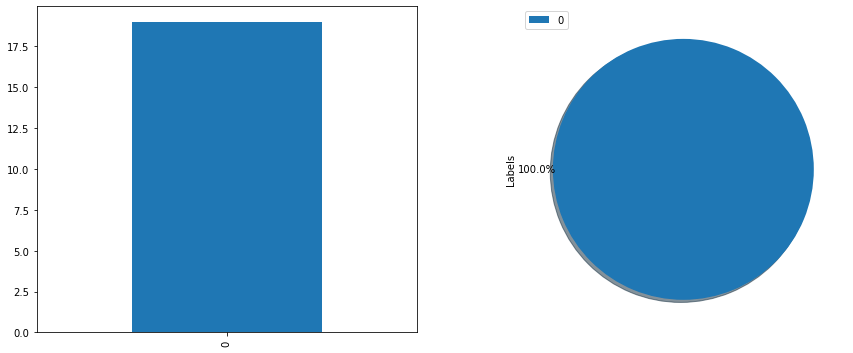

In [67]:
y = f['y_person']
fig, axs = plt.subplots(1,2)

y_df = pd.DataFrame(y)
y_df = y_df.rename(columns={0:'Labels'})
y_df_count = y_df['Labels'].value_counts()
y_df_count.plot.bar(ax=axs[0])
y_df_count.plot(kind='pie', figsize=(15, 6), autopct='%1.1f%%', shadow=True, labels=None, pctdistance=1.12, ax=axs[1])
plt.legend(labels=y_df_count.index, loc='upper left') 
plt.show()

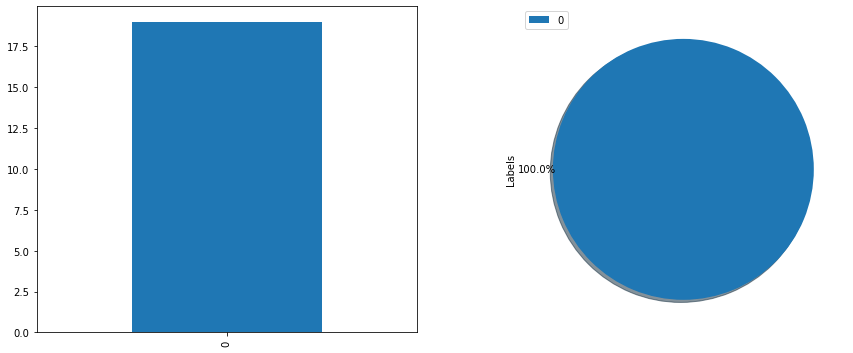

In [68]:
y = f['y_move']

fig, axs = plt.subplots(1,2)

y_df = pd.DataFrame(y)
y_df = y_df.rename(columns={0:'Labels'})
y_df_count = y_df['Labels'].value_counts()
y_df_count.plot.bar(ax=axs[0])
y_df_count.plot(kind='pie', figsize=(15, 6), autopct='%1.1f%%', shadow=True, labels=None, pctdistance=1.12, ax=axs[1])
plt.legend(labels=y_df_count.index, loc='upper left') 
plt.show()

#### 5. Testing unload data <a name="testing"></a>

In [69]:
file_ok = '2020-08-05-B0444-S01-E01-T01-K01.c3d'
file_bad = '2020-08-05-B0444-S01-E02-T04-K01.c3d'

In [70]:
def load_test(filename):
    
    print ("TEST: Analogs.from_c3d -", end =" ")
    try: emg = Analogs.from_c3d(filename, usecols=['Voltage.2']); print("ok")
    except: print("bad")
        
    print ("TEST: read_analog_to_dataframe -", end =" ")
    try: emg_df = read_analog_to_dataframe(filename); print("ok")
    except: print("bad")
        
    print ("TEST: get_actor_name_from_file -", end =" ")
    try: actor = get_actor_name_from_file(filename); print("ok")
    except: print("bad")
        
    print ("TEST: get_channel_for_actor -", end =" ")
    try: actor_channel = get_channel_for_actor(actor); print("ok")    
    except: print("bad")
    
    print ("TEST: Markers.from_c3d -", end =" ")
    try: marker = Markers.from_c3d(filename, usecols=actor_channel); print("ok")  
    except: print("bad")
        
    print ("TEST: prepare_column_sequence -", end =" ") 
    try: column_sequence = prepare_column_sequence(actor_channel); print("ok")    
    except: print("bad")
        
    print ("TEST: read_markers_to_dataframe -", end =" ")  
    try: marker_df = read_markers_to_dataframe(filename, time_normalisation=200); print("ok")    
    except: print("bad")
        
    print ("TEST: full_data -", end =" ")   
    try: full_data = marker_df.join(emg_df); print("ok")    
    except: print("bad")
        
    print ("TEST: read_all_to_dataframe -", end =" ")  
    try: x_1 = read_all_to_dataframe(filename, time_normalisation); print("ok")    
    except: print("bad")

In [71]:
file_ok = '2020-08-05-B0444-S01-E01-T01-K01.c3d'
file_bad = '2020-08-05-B0444-S01-E02-T04-K01.c3d'

In [72]:
load_test(file_ok)

TEST: Analogs.from_c3d - ok
TEST: read_analog_to_dataframe - ok
TEST: get_actor_name_from_file - ok
TEST: get_channel_for_actor - ok
TEST: Markers.from_c3d - ok
TEST: prepare_column_sequence - ok
TEST: read_markers_to_dataframe - ok
TEST: full_data - ok
TEST: read_all_to_dataframe - ok


In [73]:
load_test(file_bad)

TEST: Analogs.from_c3d - bad
TEST: read_analog_to_dataframe - bad
TEST: get_actor_name_from_file - ok
TEST: get_channel_for_actor - ok
TEST: Markers.from_c3d - bad
TEST: prepare_column_sequence - ok
TEST: read_markers_to_dataframe - bad
TEST: full_data - bad
TEST: read_all_to_dataframe - bad


#### 7. Lekko zmieniony podział plików

In [74]:
def cropp_c3dfile(eventsFrame, filename, destiny):
    reader = btk.btkAcquisitionFileReader()
    reader.SetFilename(filename)
    reader.Update()
    acq = reader.GetOutput()
 
    writer = btk.btkAcquisitionFileWriter()
    
    for i in range(0, len(eventsFrame)):
        clone = acq.Clone();
        clone.ResizeFrameNumberFromEnd(acq.GetLastFrame() - eventsFrame[i][0] + 1)
        clone.ResizeFrameNumber(eventsFrame[i][1] - eventsFrame[i][0] + 1)
        clone.SetFirstFrame(eventsFrame[i][0])
        clone.ClearEvents()
        for e in btk.Iterate(acq.GetEvents()):
            if ((e.GetFrame() > clone.GetFirstFrame()) and (e.GetFrame() < clone.GetLastFrame())):
                  clone.AppendEvent(e)
        clone.SetFirstFrame(1)
        writer.SetInput(clone)
        writer.SetFilename(destiny + '\\' + (filename.split('\\')[-1]).split('.')[0]+ '-K' + str(i+1) + '.c3d')
        writer.Update()

```python
importlib.reload(dp)
destiny = r'C:\Users\Grafika Multimedia\Desktop\Miecze_Praktyki\baza'
for path in Path(r'C:\Users\Grafika Multimedia\Desktop\Miecze_Praktyki').rglob('*.c3d'):
    czas = dp.read_labels(str(path),200)
    temp = []
    for i in range(len(czas[0])):
        if czas[0][i] != 0 and czas[1][i] != 0:
            temp.append([int(czas[0][i]), int(czas[1][i])])  
    dp.cropp_c3dfile(temp, str(path), str(destiny))
```

In [75]:
def read_labels(data_path,frame_rate):  
    c3d_to_compare= c3d(data_path)
    event = c3d_to_compare['parameters']['EVENT']['LABELS']['value']
    czas = np.around(c3d_to_compare['parameters']['EVENT']['TIMES']['value'][1]*frame_rate)
    eventy = [event, czas]
    
    eventy[0].index('Foot Strike')
    indxE = [i for i, x in enumerate(eventy[0]) if x == "Event"]
    indxFS = [i for i, x in enumerate(eventy[0]) if x == "Foot Strike"]

    CzasFS = np.zeros(len(indxFS))
    for i in range(len(indxFS)):
        CzasFS[i] = eventy[1][indxFS[i]]

    CzasE = np.zeros(len(indxE))
    for i in range(len(indxE)):
        CzasE[i] = eventy[1][indxE[i]]
    eventy[1].sort()

    p = []
    k = []
    for i in range(len(eventy[1])):
        if not i >= len(eventy[1])-2:
            pierwszy = eventy[1][i]
            drugi = eventy[1][i+1]
            trzeci = eventy[1][i+2]
            if pierwszy in CzasE:
                if drugi in CzasFS:
                    if trzeci in CzasE:
                        p.append(int(pierwszy))
                        k.append(int(trzeci))
    return [p,k]

In [76]:
from ezc3d import c3d
test_file = "2020-08-05-B0444-S01-E02-T04.c3d"
temp = read_labels(test_file, 200)

In [77]:
import btk

In [78]:
cropp_c3dfile(temp, test_file, r"C:\Users\Konrad\Experiments2020\PhD Jupyter notebooks")

In [79]:
files = ["2020-08-05-B0444-S01-E02-T04-K1.c3d",
        "2020-08-05-B0444-S01-E02-T04-K2.c3d",
        "2020-08-05-B0444-S01-E02-T04-K3.c3d",
        "2020-08-05-B0444-S01-E02-T04-K4.c3d",
        "2020-08-05-B0444-S01-E02-T04-K5.c3d",
        "2020-08-05-B0444-S01-E02-T04-K6.c3d",
        "2020-08-05-B0444-S01-E02-T04-K7.c3d",
        "2020-08-05-B0444-S01-E02-T04-K8.c3d",
        "2020-08-05-B0444-S01-E02-T04-K9.c3d",
        "2020-08-05-B0444-S01-E02-T04-K10.c3d"]

for f in files:
    print ("\n =============================")
    print(f, "testing")
    load_test(f)


2020-08-05-B0444-S01-E02-T04-K1.c3d testing
TEST: Analogs.from_c3d - ok
TEST: read_analog_to_dataframe - ok
TEST: get_actor_name_from_file - ok
TEST: get_channel_for_actor - ok
TEST: Markers.from_c3d - ok
TEST: prepare_column_sequence - ok
TEST: read_markers_to_dataframe - ok
TEST: full_data - ok
TEST: read_all_to_dataframe - ok

2020-08-05-B0444-S01-E02-T04-K2.c3d testing
TEST: Analogs.from_c3d - ok
TEST: read_analog_to_dataframe - ok
TEST: get_actor_name_from_file - ok
TEST: get_channel_for_actor - ok
TEST: Markers.from_c3d - ok
TEST: prepare_column_sequence - ok
TEST: read_markers_to_dataframe - ok
TEST: full_data - ok
TEST: read_all_to_dataframe - ok

2020-08-05-B0444-S01-E02-T04-K3.c3d testing
TEST: Analogs.from_c3d - bad
TEST: read_analog_to_dataframe - bad
TEST: get_actor_name_from_file - ok
TEST: get_channel_for_actor - ok
TEST: Markers.from_c3d - bad
TEST: prepare_column_sequence - ok
TEST: read_markers_to_dataframe - bad
TEST: full_data - bad
TEST: read_all_to_dataframe - ba

In [80]:
emg = Analogs.from_c3d("2020-08-05-B0444-S01-E02-T04-K2.c3d", usecols=['Voltage.2'])

#### 7. Testing GRF and Moments

a. Which file don'tcontain GRF or angles.

In [81]:
c_platform = ["RGroundReactionMoment","RGroundReactionForce"]

c_angles = ["LHipAngles","LKneeAngles","LAnkleAngles",
          "RHipAngles","RKneeAngles","RAnkleAngles",
          "LShoulderAngles","LElbowAngles","LWristAngles",
          "RShoulderAngles","RElbowAngles","RWristAngles"]
all_chanels = c_markers + c_platform + c_angles 

In [82]:
def check_files(filepath):
    filenames = get_filenames_form_path(filepath)
    
    bad_files =[]
    
    for file in tqdm(filenames, desc="Loading: "):
        try: marker_df = read_markers_to_dataframe(file, time_normalisation)
        except:
            bad_files.append(file)
            print(file)
            
    return bad_files

In [ ]:
grf_lost = check_files(r"\\172.16.10.4\Praktyki2020\kk_database")

Loading:   0%|                                | 1/3809 [00:00<11:17,  5.62it/s]

Load filenames: 3809 - we expect 15 person * 5 moves * 10 times = 3 750 filenames


Loading:   1%|▏                              | 29/3809 [00:04<08:27,  7.45it/s]

\\172.16.10.4\Praktyki2020\kk_database\2020-08-05-B0444-S01-E01-T03-K7.c3d


Loading:   1%|▎                              | 31/3809 [00:04<08:10,  7.70it/s]

\\172.16.10.4\Praktyki2020\kk_database\2020-08-05-B0444-S01-E01-T03-K9.c3d


Loading:   1%|▎                              | 38/3809 [00:05<08:08,  7.72it/s]

\\172.16.10.4\Praktyki2020\kk_database\2020-08-05-B0444-S01-E01-T04-K6.c3d


Loading:   1%|▎                              | 46/3809 [00:06<09:49,  6.38it/s]

\\172.16.10.4\Praktyki2020\kk_database\2020-08-05-B0444-S01-E01-T05-K4.c3d


Loading:   1%|▍                              | 55/3809 [00:08<09:07,  6.86it/s]

\\172.16.10.4\Praktyki2020\kk_database\2020-08-05-B0444-S01-E02-T01-K2.c3d


Loading:   3%|▊                              | 97/3809 [00:14<08:38,  7.16it/s]

In [ ]:
len(grf_lost)